## This code file is not the final model code. This code file is an initial version, but it is comparative and representative, so it is retained in many code files.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
import ast

# Read data
df = pd.read_csv('audio_features.csv')

# Define functions for parsing arrays
def parse_array(column):
    # Remove newlines and extra spaces in the array, and then use ast.literal_eval to parse
    clean_str = re.sub(r'\s+', ',', column.strip())
    clean_str = clean_str.replace('[,', '[').replace(',,', ',')
    return np.array(ast.literal_eval(clean_str))

# Apply parsing function
df['MFCCs'] = df['MFCCs'].apply(parse_array)
df['Chroma_Features'] = df['Chroma_Features'].apply(parse_array)

# Extract features and target variables
X = df.drop(columns=['C_val', 'M_val', 'D_val'])
y = df[['C_val', 'M_val', 'D_val']]

# Standardize features except MFCCs and Chroma_Features
scalar_features = X.drop(columns=['MFCCs', 'Chroma_Features'])
scaler = StandardScaler()
scalar_features_scaled = scaler.fit_transform(scalar_features)

#Convert MFCCs and Chroma_Features to arrays
mfccs = np.stack(X['MFCCs'].values)
chroma = np.stack(X['Chroma_Features'].values)

# Combined features
X_combined = np.hstack([scalar_features_scaled, mfccs, chroma])

# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Verify data
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)




(436480, 35) (109120, 35)
(436480, 3) (109120, 3)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, concatenate

# Assume that MFCCs have 13 coefficients and other features are 1 each
num_mfccs = mfccs.shape[1]
num_spectral_features = scalar_features_scaled.shape[1]
num_chroma_features = chroma.shape[1]

# define input
input_mfccs = Input(shape=(num_mfccs, 1))
input_spectral = Input(shape=(num_spectral_features,))
input_chroma = Input(shape=(num_chroma_features, 1))

# CNN model part
x = Conv1D(32, kernel_size=3, activation='relu')(input_mfccs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# RNN model part
y = LSTM(64, return_sequences=True)(input_chroma)
y = LSTM(64)(y)

# Merge CNN and RNN output
combined = concatenate([x, input_spectral, y])

# Fully connected layer
z = Dense(128, activation='relu')(combined)
z = Dense(64, activation='relu')(z)
output = Dense(3)(z)  # Output 3 parameters C, M, D

# Build model
model = Model(inputs=[input_mfccs, input_spectral, input_chroma], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 18, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 9, 32)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     16,896 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 288)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 355)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     45,568 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        195 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,067 (406.51 KB)

 Trainable params: 104,067 (406.51 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Split features into different parts
mfccs_train = X_train[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_train = X_train[:, :-num_mfccs - num_chroma_features]  # Assume the rest are other features
chroma_train = X_train[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)  # Adjust chroma features to three dimensions

mfccs_test = X_test[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_test = X_test[:, :-num_mfccs - num_chroma_features]
chroma_test = X_test[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)

# Define callback function
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train model
history = model.fit(
    [mfccs_train, spectral_train, chroma_train], y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 24260.5195 - val_loss: 2246.2009
Epoch 2/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 1727.1067 - val_loss: 1308.3281
Epoch 3/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 964.1620 - val_loss: 591.6736
Epoch 4/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 673.7812 - val_loss: 384.9391
Epoch 5/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 518.5881 - val_loss: 309.6035
Epoch 6/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 412.9816 - val_loss: 250.0126
Epoch 7/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 322.6709 - val_loss: 203.5202
Epoch 8/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 299.0999 - val_loss: 361.2497
Epoch 9/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 250.3068 - val_loss: 213.0745
Epoch 10/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 216.0857 - val_loss: 262.7043
Epoch 11/50
10912/10912 ━━━━━━━━━━━━━━━━━━━━

3410/3410 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Mean Squared Error: 36.45090461741581
R² Score: 0.9603054106496306


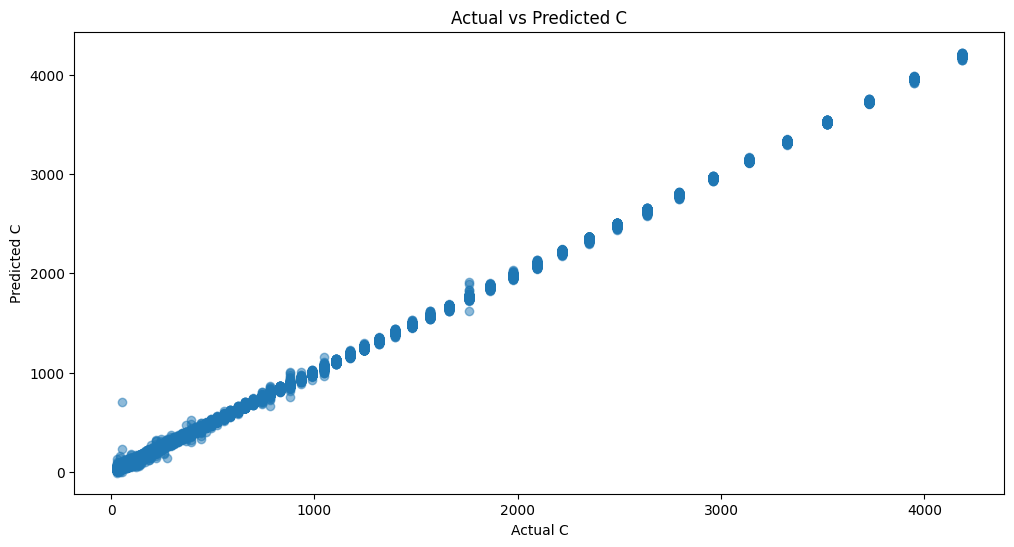

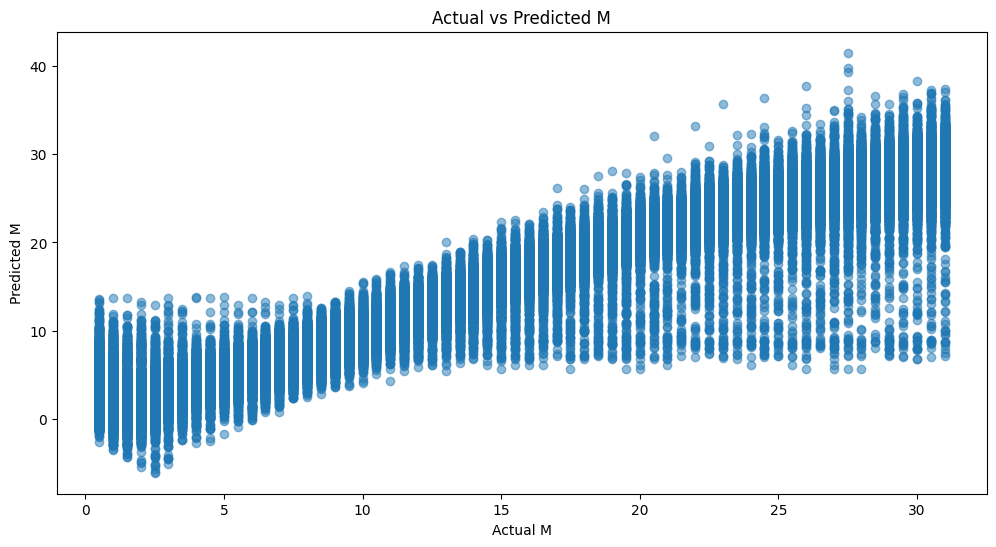

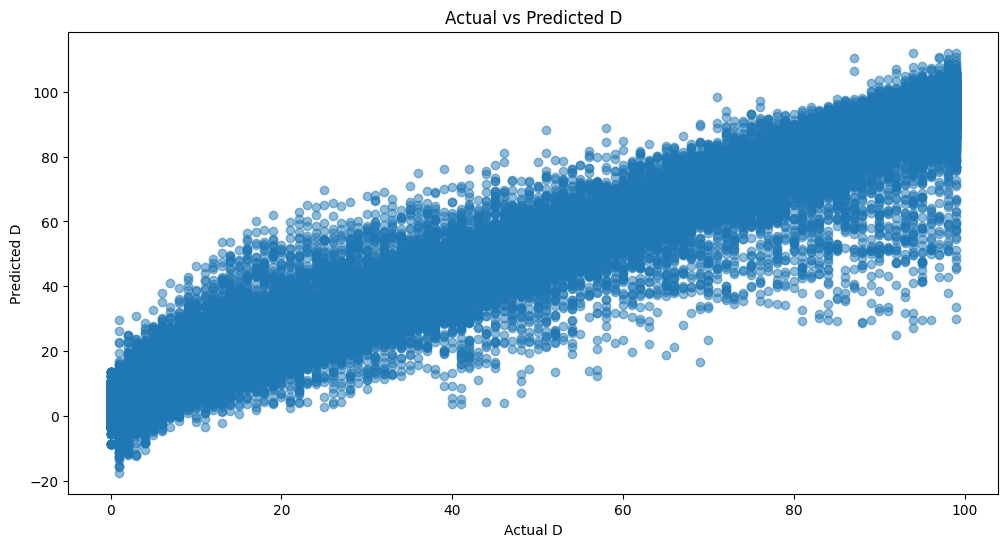

In [4]:
# Evaluate the model
y_pred = model.predict([mfccs_test, spectral_test, chroma_test])

# Calculate evaluation indicators
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Visualize prediction results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(y_test['C_val'], y_pred[:, 0], alpha=0.5)
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Actual vs Predicted C')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_test['M_val'], y_pred[:, 1], alpha=0.5)
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Actual vs Predicted M')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_test['D_val'], y_pred[:, 2], alpha=0.5)
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Actual vs Predicted D')
plt.show()


In [5]:
# Read new data
new_df = pd.read_csv('audio_features_test.csv')

# Apply previous parsing and preprocessing functions
new_df['MFCCs'] = new_df['MFCCs'].apply(parse_array)
new_df['Chroma_Features'] = new_df['Chroma_Features'].apply(parse_array)

# Extract features and target variables
X_new = new_df.drop(columns=['C_val', 'M_val', 'D_val'])
y_new = new_df[['C_val', 'M_val', 'D_val']]

# Standardize features except MFCCs and Chroma_Features
scalar_features_new = X_new.drop(columns=['MFCCs', 'Chroma_Features'])
scalar_features_scaled_new = scaler.transform(scalar_features_new)

# Convert MFCCs and Chroma_Features to arrays
mfccs_new = np.stack(X_new['MFCCs'].values)
chroma_new = np.stack(X_new['Chroma_Features'].values)

# Combined features
X_combined_new = np.hstack([scalar_features_scaled_new, mfccs_new, chroma_new])


1964/1964 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Mean Squared Error on new data: 472.42867438816523
R² Score on new data: 0.9171607913131736


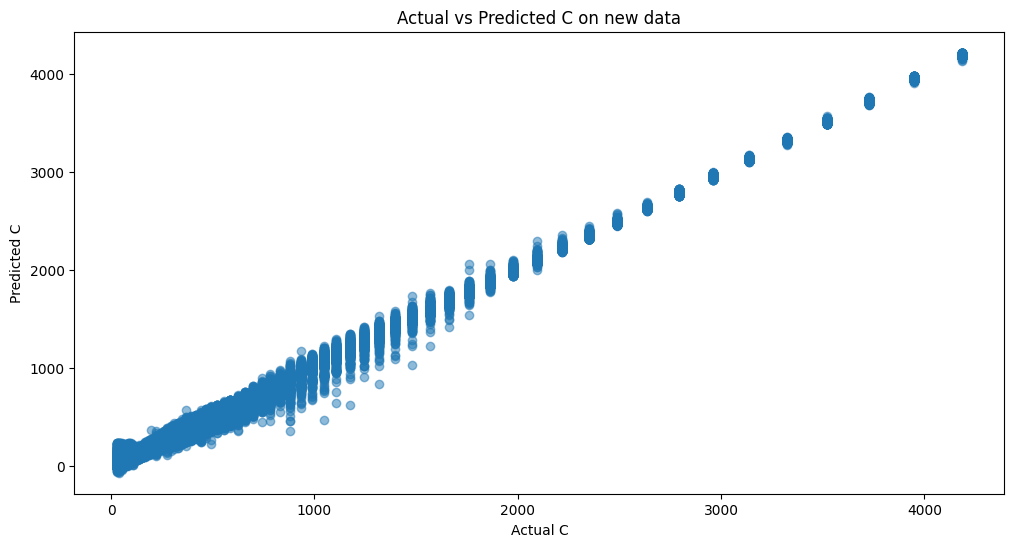

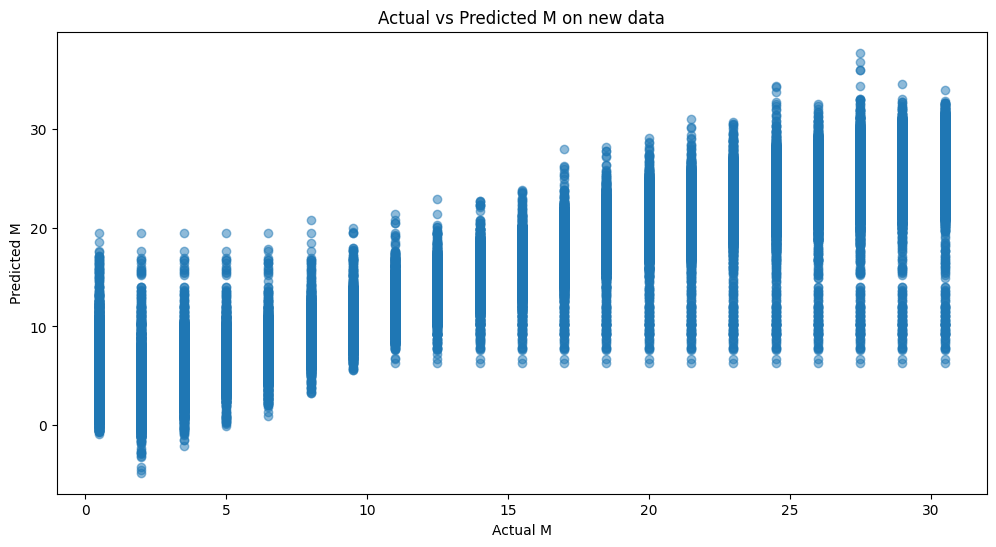

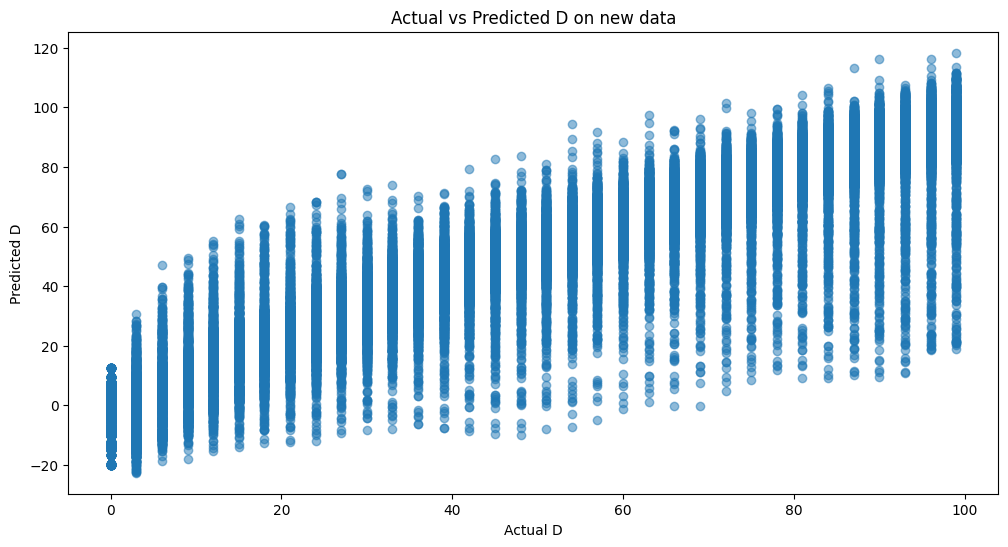

In [ ]:
# Split the features of the new dataset into different parts
mfccs_new_test = X_combined_new[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_new_test = X_combined_new[:, :-num_mfccs - num_chroma_features]
chroma_new_test = X_combined_new[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)

# Evaluate the performance of the model on the new data set
y_pred_new = model.predict([mfccs_new_test, spectral_new_test, chroma_new_test])

# Calculate evaluation indicators
mse_new = mean_squared_error(y_new, y_pred_new)
r2_new = r2_score(y_new, y_pred_new)

print(f'Mean Squared Error on new data: {mse_new}')
print(f'R² Score on new data: {r2_new}')

# Visualize prediction results
plt.figure(figsize=(12, 6))
plt.scatter(y_new['C_val'], y_pred_new[:, 0], alpha=0.5)
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Actual vs Predicted C on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new['M_val'], y_pred_new[:, 1], alpha=0.5)
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Actual vs Predicted M on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new['D_val'], y_pred_new[:, 2], alpha=0.5)
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Actual vs Predicted D on new data')
plt.show()


1964/1964 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Squared Error on new data: 636.8853699962197
R² Score on new data: 0.885380171578673


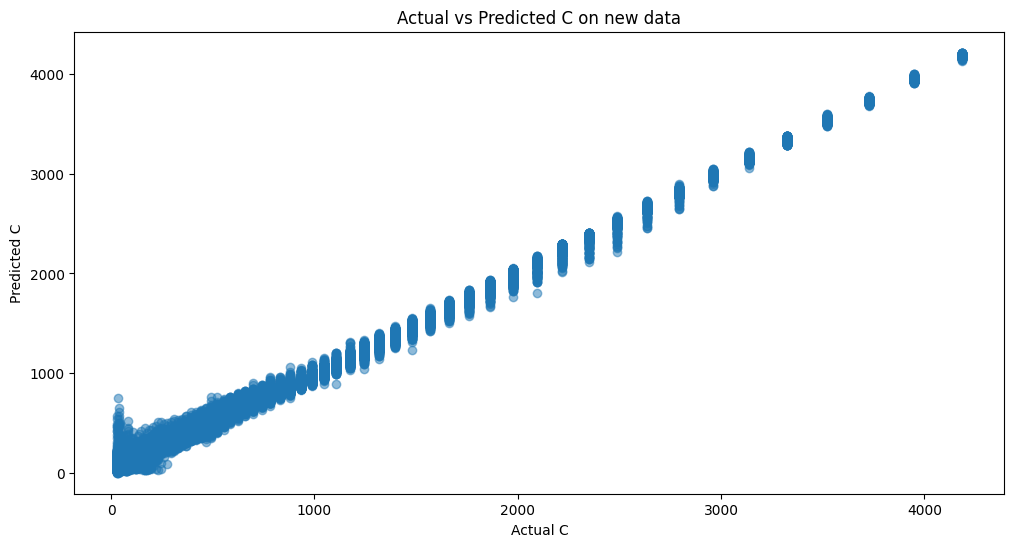

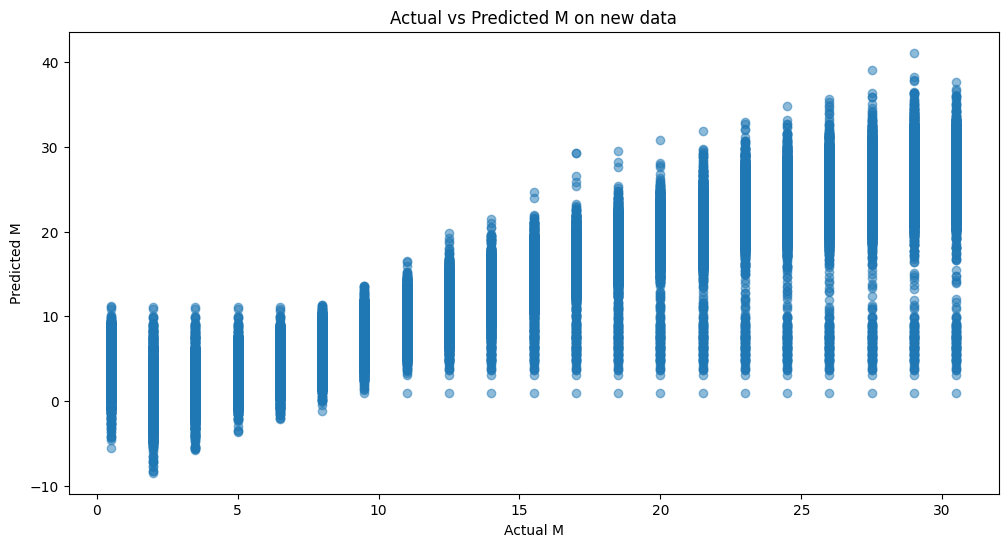

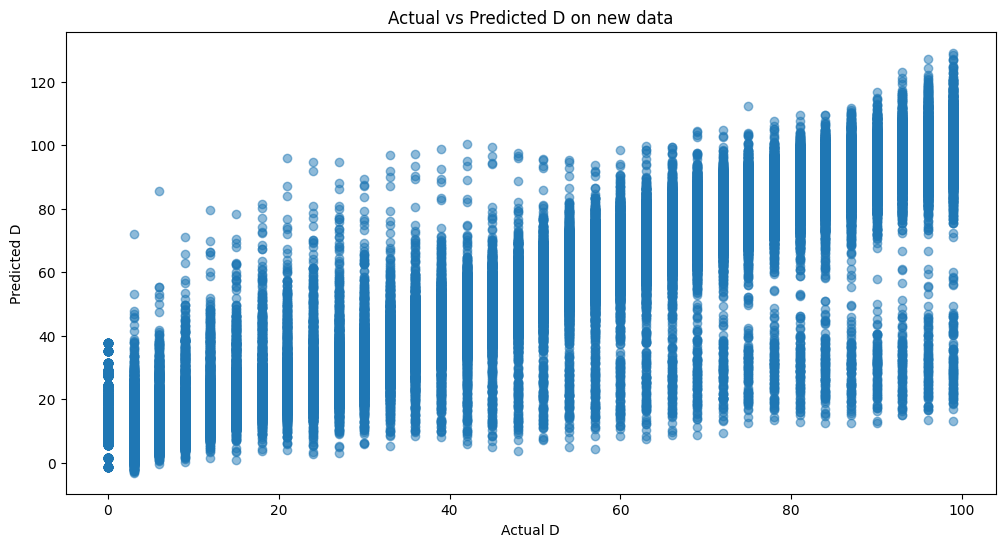

In [9]:
# Read new data
new2_df = pd.read_csv('audio_features_test2.csv')

# Apply previous parsing and preprocessing functions
new2_df['MFCCs'] = new2_df['MFCCs'].apply(parse_array)
new2_df['Chroma_Features'] = new2_df['Chroma_Features'].apply(parse_array)

# Extract features and target variables
X_new2 = new2_df.drop(columns=['C_val', 'M_val', 'D_val'])
y_new2 = new2_df[['C_val', 'M_val', 'D_val']]

# Standardize features except MFCCs and Chroma_Features
scalar_features_new2 = X_new2.drop(columns=['MFCCs', 'Chroma_Features'])
scalar_features_scaled_new2 = scaler.transform(scalar_features_new2)

# Convert MFCCs and Chroma_Features to arrays
mfccs_new2 = np.stack(X_new2['MFCCs'].values)
chroma_new2 = np.stack(X_new2['Chroma_Features'].values)

# Combined features
X_combined_new2 = np.hstack([scalar_features_scaled_new2, mfccs_new2, chroma_new2])

# Split the features of the new dataset into different parts
mfccs_new2_test = X_combined_new2[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_new2_test = X_combined_new2[:, :-num_mfccs - num_chroma_features]
chroma_new2_test = X_combined_new2[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)

# Evaluate the performance of the model on the new data set
y_pred_new2 = model.predict([mfccs_new2_test, spectral_new2_test, chroma_new2_test])

# Calculate evaluation indicators
mse_new2 = mean_squared_error(y_new2, y_pred_new2)
r2_new2 = r2_score(y_new2, y_pred_new2)

print(f'Mean Squared Error on new data: {mse_new2}')
print(f'R² Score on new data: {r2_new2}')

# Visualize prediction results
plt.figure(figsize=(12, 6))
plt.scatter(y_new2['C_val'], y_pred_new2[:, 0], alpha=0.5)
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Actual vs Predicted C on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new2['M_val'], y_pred_new2[:, 1], alpha=0.5)
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Actual vs Predicted M on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new2['D_val'], y_pred_new2[:, 2], alpha=0.5)
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Actual vs Predicted D on new data')
plt.show()